In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# data manipulation
import pandas as pd
from time import time
from multiprocessing import Pool

# data viz
from matplotlib import rcParams
import seaborn as sns
import math
import umap
import hdbscan
# apply some cool styling
plt.style.use("ggplot")
#rcParams['figure.figsize'] = (10,  5)

In [4]:
def magnitude(sample):
    mag_vector = []
    for s in sample:
        mag_vector.append(math.sqrt(sum([s[0]**2, s[1]**2, s[2]**2])))
    return mag_vector

def A(sample):
    feat = []
    for col in range(0,sample.shape[1]):
        average = np.average(sample[:, col])
        feat.append(average)

    return np.mean(feat)


def SD(sample):
    feat = []
    for col in range(0, sample.shape[1]):
        std = np.std(sample[:, col])
        feat.append(std)

    return np.mean(feat)


def AAD(sample):
    feat = []
    for col in range(0, sample.shape[1]):
        data = sample[col,:]
        add = np.mean(np.absolute(data - np.mean(data)))
        feat.append(add)

    return np.mean(feat)


def ARA(sample):
    #Average Resultant Acceleration[1]:
    # Average of the square roots of the sum of the values of each axis squared √(xi^2 + yi^2+ zi^2) over the ED
    feat = []
    sum_square = 0
    sample = np.power(sample, 2)
    for col in range(0, sample.shape[1]):
        sum_square = sum_square + sample[:, col]

    sample = np.sqrt(sum_square)
    average = np.average(sample)
    feat.append(average)
    return np.mean(feat)

def COR(sample):
    feat = []
    for axis_i in range(0, sample.shape[1]):
        for axis_j in range(axis_i+1, sample.shape[1]):
            cor = np.corrcoef(sample[:, axis_i], sample[:, axis_j])
            cor = 0 if np.isnan(cor) else cor[0][1]
            feat.append(cor)

    return np.mean(feat)


def mag_mean(sample):
    mag = magnitude(sample)
    ft_mean = np.mean(mag)
    return ft_mean

def mag_std(sample):
    mag = magnitude(sample)
    ft_std = np.std(mag)
    return ft_std


def feature_extraction(sample):
    """
    Derive three activity intensity cues: mean and standard deviation of activity intensity,
    and duration of immobility during assessment window to summarize the data.
    # Average - A,
    # Standard Deviation - SD,
    # Average Absolute Difference - AAD,
    # Average Resultant Acceleration - ARA(1),
    """
    features = []

    mag = magnitude(sample)
    features = np.mean(mag)
    features = np.hstack((features, np.std(mag)))
    features = np.hstack((features, A(sample)))
    features = np.hstack((features, SD(sample)))
    features = np.hstack((features, AAD(sample)))
    features = np.hstack((features, ARA(sample)))

    return features

In [5]:
data_input_file = "/home/jsenadesouza/DA-healthy2patient/results/outcomes/dataset/t900_INTELLIGENT_ADAPT_PAIN_15wd_15drop_painprev.npz"
tmp = np.load(data_input_file, allow_pickle=True)
X = tmp["X"]
y = tmp['y']
y_col_names = list(tmp['y_col_names'])

In [6]:
def clean(X, y, col_target):
    if '-1' in np.unique(y[:, col_target]):
        idxs = np.argwhere(np.array(y[:, col_target]) != '-1')
        X = X[idxs]
        y = y[idxs]
    return np.squeeze(X), np.squeeze(y)

col_idx_target = y_col_names.index("pain_score_class")
X, y = clean(X, y, col_idx_target)
y_target = y[:, col_idx_target]
y_target = [0 if yy== "mild" else 1 for yy in y_target]

In [7]:
X_trasp = np.transpose(np.squeeze(X), (0, 1, 2))
print("Extracting Features")
start = time()
with Pool(30) as p:
        X_feat = p.map(feature_extraction, X_trasp)
end = time()
print(f"{end-start:.4} seconds passed.")


Extracting Features
22.74 seconds passed.


In [11]:
X_feat = np.array(X_feat)

In [21]:
y_target = np.array(y_target)

In [42]:
X_concat = np.concatenate([X_feat, np.expand_dims(y_target, axis=1)], axis=1)

In [43]:
df_X = pd.DataFrame(X_concat, columns=["mean_mag", "std_mag", "average", "sd", "AAD", "ARA", "target"], dtype=float)

In [44]:
df_X.describe()

,mean_mag,std_mag,average,sd,AAD,ARA,target
count,12623.000000,1.262300e+04,12623.000000,1.262300e+04,12623.000000,12623.000000,12623.000000
mean,3.497798,2.360044e-01,0.770938,5.984820e-01,1.364206,3.497798,0.180860
std,4.218909,4.475778e-01,1.944669,8.875885e-01,1.583807,4.218909,0.384918
min,0.974348,3.330669e-16,-2.736888,1.491862e-16,0.178074,0.974348,0.000000
25%,1.000806,1.442213e-02,-0.189174,1.316507e-01,0.371926,1.000806,0.000000
50%,1.013410,3.881681e-02,0.146597,2.888465e-01,0.493926,1.013410,0.000000
75%,7.351415,2.054429e-01,0.472020,4.982719e-01,2.249597,7.351415,0.000000
max,26.193985,2.433491e+00,14.088837,4.864824e+00,4.921900,26.193985,1.000000


In [45]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12623 entries, 0 to 12622
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mean_mag  12623 non-null  float64
 1   std_mag   12623 non-null  float64
 2   average   12623 non-null  float64
 3   sd        12623 non-null  float64
 4   AAD       12623 non-null  float64
 5   ARA       12623 non-null  float64
 6   target    12623 non-null  float64
dtypes: float64(7)
memory usage: 690.4 KB


In [46]:
df_X.duplicated().sum()

12493

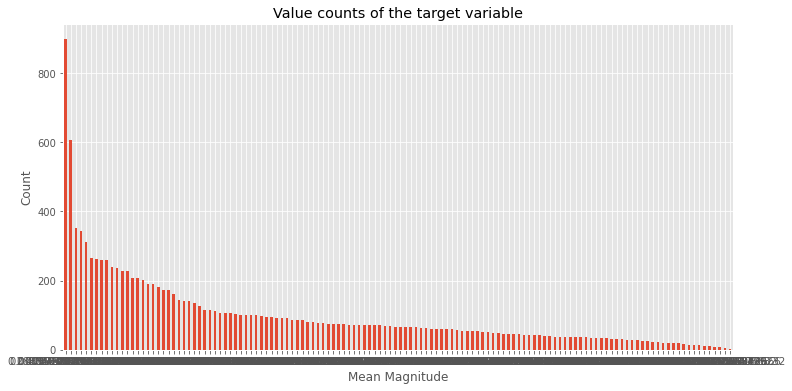

In [47]:
df_X.sd.value_counts().plot(kind="bar")
plt.title("Value counts of the target variable")
plt.xlabel("Mean Magnitude")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

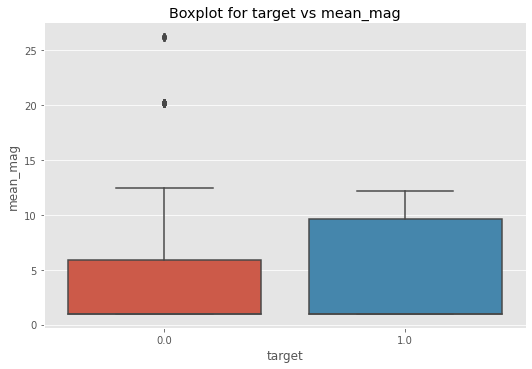

In [48]:
sns.catplot(x="target", y="mean_mag", data=df_X, kind="box", aspect=1.5)
plt.title("Boxplot for target vs mean_mag")
plt.show()

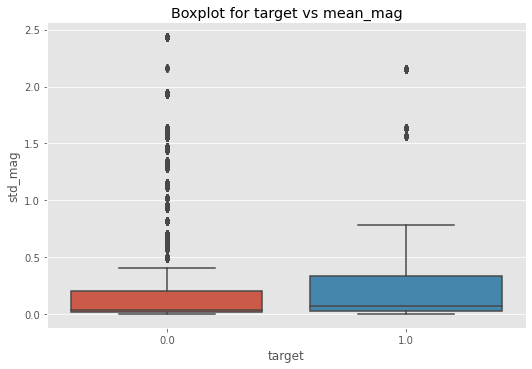

In [49]:
sns.catplot(x="target", y="std_mag", data=df_X, kind="box", aspect=1.5)
plt.title("Boxplot for target vs mean_mag")
plt.show()

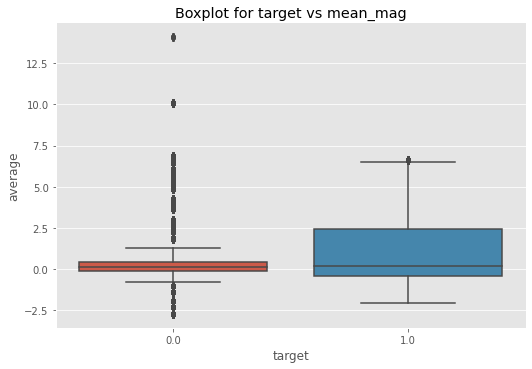

In [50]:
sns.catplot(x="target", y="average", data=df_X, kind="box", aspect=1.5)
plt.title("Boxplot for target vs mean_mag")
plt.show()

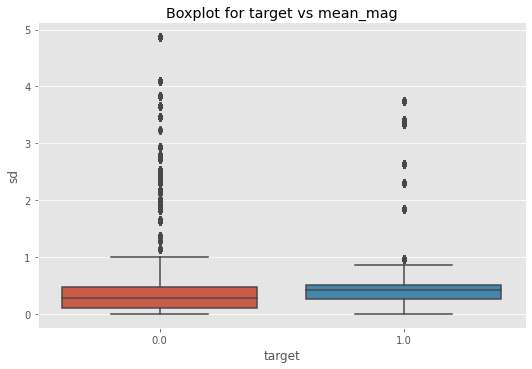

In [51]:
sns.catplot(x="target", y="sd", data=df_X, kind="box", aspect=1.5)
plt.title("Boxplot for target vs mean_mag")
plt.show()

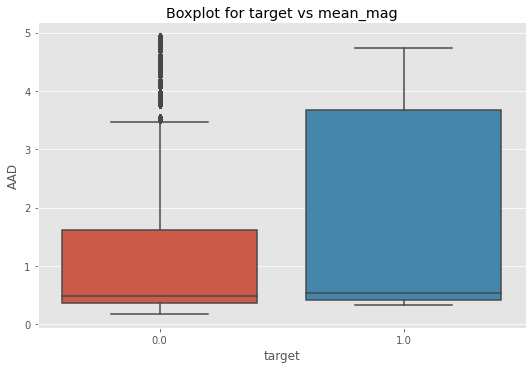

In [52]:
sns.catplot(x="target", y="AAD", data=df_X, kind="box", aspect=1.5)
plt.title("Boxplot for target vs mean_mag")
plt.show()

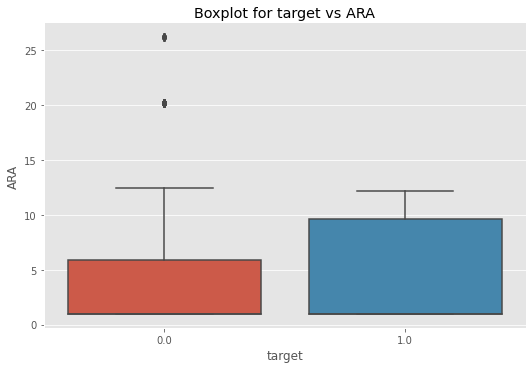

In [53]:
sns.catplot(x="target", y="ARA", data=df_X, kind="box", aspect=1.5)
plt.title("Boxplot for target vs ARA")
plt.show()

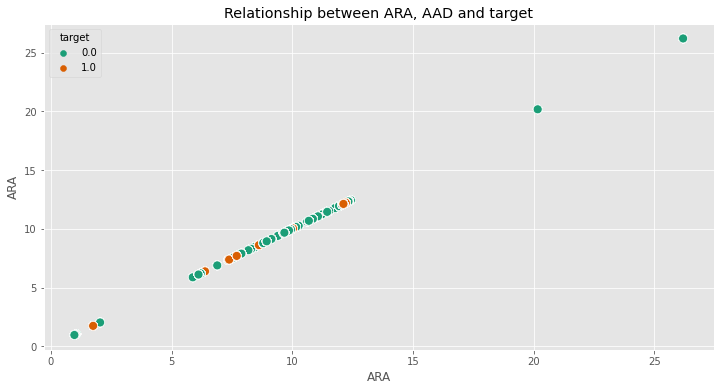

In [54]:
sns.scatterplot(x="ARA", y="ARA", hue="target", data=df_X, palette="Dark2", s=80)
plt.title("Relationship between ARA, AAD and target")
plt.show()

/home/jsenadesouza/.conda/envs/jessica/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/jsenadesouza/.conda/envs/jessica/lib/python3.9/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/home/jsenadesouza/.conda/envs/jessica/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/ho

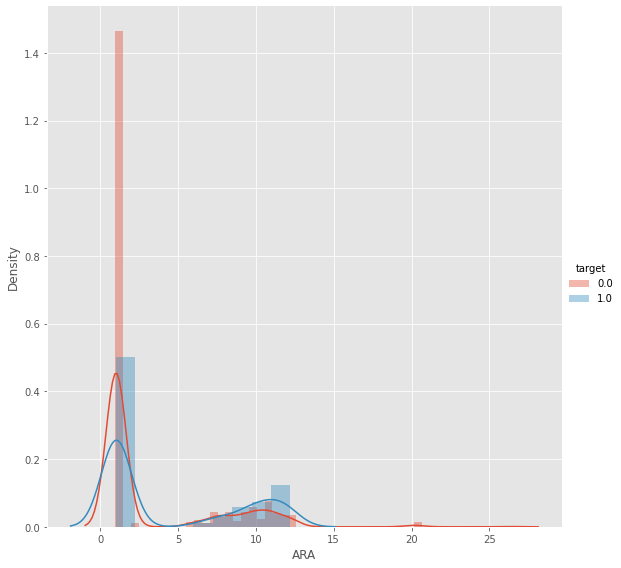

In [55]:
sns.FacetGrid(df_X, hue = "target", height=8).map(sns.distplot, "ARA").add_legend()

# Target Cluster by patient

In [34]:
def get_cmap(n, name='gist_rainbow'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def print_by_class(n_class, finalDf, exp_name, y_new):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('First Component', fontsize=15)
    ax.set_ylabel('Second Component', fontsize=15)
    ax.set_title(exp_name, fontsize=20)
    cmap = get_cmap(n_class, name='Set1')
    targets = np.unique(y_new)
    colors = []
    for i in range(n_class):
        colors.append(cmap(i))

    for target, color in zip(targets, colors):
        indicesToKeep = finalDf['label'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'First Component']
                   , finalDf.loc[indicesToKeep, 'Second Component']
                   , color=color
                   , s=50)
    ax.legend(targets)
    ax.grid()
    plt.show()
    #plt.savefig(exp_name + '.png')
    
    
def plot_patient(X, y, exp_name):
    n_class= len(np.unique(y))
    embedding = umap.UMAP(
        n_neighbors=10,
        min_dist=0.0,
        n_components=2,
        random_state=42#,
        #metric='cosine'
    ).fit_transform(X)

    principalDf = pd.DataFrame(data=embedding, columns=['First Component', 'Second Component'])

    labels = hdbscan.HDBSCAN(
        min_samples=10,
        min_cluster_size=500,
    ).fit_predict(embedding)

    yDf = pd.DataFrame(data=np.array(y), columns=['label'])
    finalDf = pd.concat([principalDf, yDf], axis=1)
    print_by_class(n_class, finalDf, exp_name, y)

In [20]:
y_target.shape

AttributeError: 'list' object has no attribute 'shape'

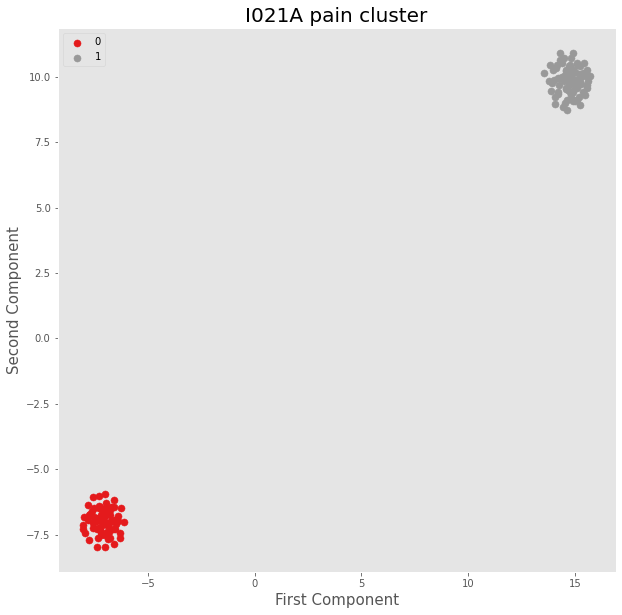

In [36]:
pat = "I021A"
idxs = np.where(y[:, -1] == pat)[0]
X_pat, y_pat = X_feat[idxs], y_target[idxs]
plot_patient(X_pat, y_pat, f"{pat} pain cluster")

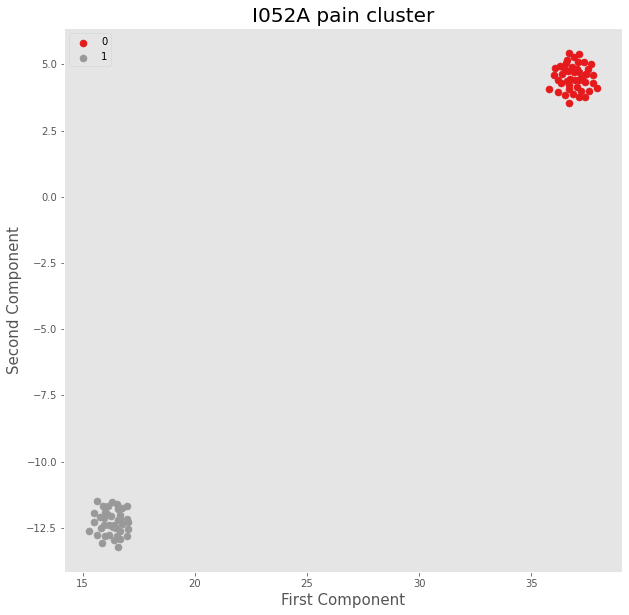

In [37]:
pat = "I052A"
idxs = np.where(y[:, -1] == pat)[0]
X_pat, y_pat = X_feat[idxs], y_target[idxs]
plot_patient(X_pat, y_pat, f"{pat} pain cluster")

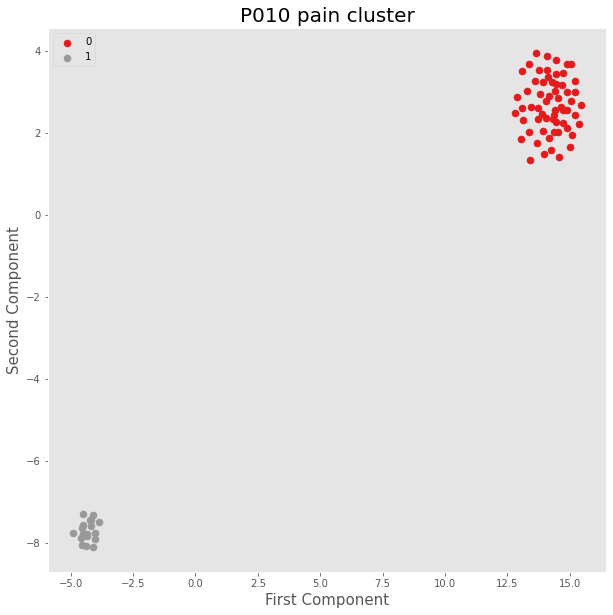

In [38]:
pat = "P010"
idxs = np.where(y[:, -1] == pat)[0]
X_pat, y_pat = X_feat[idxs], y_target[idxs]
plot_patient(X_pat, y_pat, f"{pat} pain cluster")

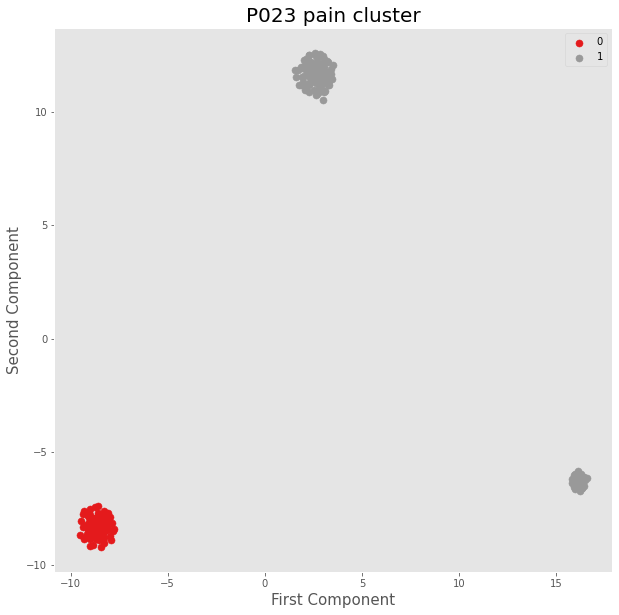

In [39]:
pat = "P023"
idxs = np.where(y[:, -1] == pat)[0]
X_pat, y_pat = X_feat[idxs], y_target[idxs]
plot_patient(X_pat, y_pat, f"{pat} pain cluster")

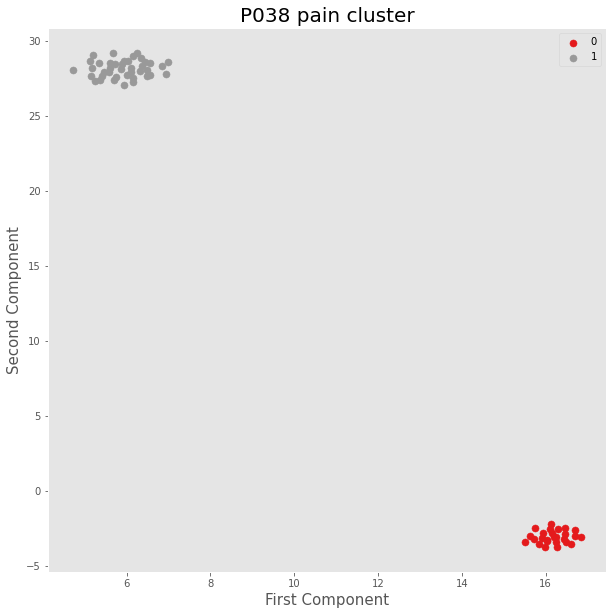

In [40]:
pat = "P038"
idxs = np.where(y[:, -1] == pat)[0]
X_pat, y_pat = X_feat[idxs], y_target[idxs]
plot_patient(X_pat, y_pat, f"{pat} pain cluster")

In [15]:
np.where(y[:, -1] == pat)[0]

array([11671, 11672, 11673, 11674, 11675, 11676, 11677, 11678, 11679,
       11680, 11681, 11682, 11683, 11684, 11685, 11686, 11687, 11688,
       11689, 11690, 11691, 11692, 11693, 11694, 11695, 11696, 11697,
       11698, 11699, 11700, 11701, 11702, 11703, 11704, 11705, 11706,
       11707, 11708, 11709, 11710, 11711, 11712, 11713, 11714, 11715,
       11716, 11717, 11718, 11719, 11720, 11721, 11722, 11723, 11724,
       11725, 11726, 11727, 11728, 11729, 11730, 11731, 11732, 11733,
       11734, 11735, 11736, 11737, 11738, 11739, 11740, 11741, 11742,
       11743, 11744, 11745, 11746, 11747, 11748, 11749, 11750, 11751,
       11752, 11753, 11754, 11755, 11756, 11757, 11758, 11759, 11760,
       11761, 11762, 11763, 11764, 11765, 11766, 11767, 11768, 11769,
       11770, 11771, 11772, 11773, 11774, 11775, 11776, 11777, 11778,
       11779, 11780, 11781, 11782, 11783, 11784, 11785, 11786, 11787,
       11788, 11789, 11790, 11791, 11792, 11793, 11794, 11795, 11796,
       11797, 11798,